Reinforcement Learning: An Introduction (Richard S. Sutton and Andrew G. Barto)
Example 4.2: Jack’s Car Rental

iter_cnt: 1
policy_improvement
iter_cnt: 2
policy_improvement
iter_cnt: 3
policy_improvement
iter_cnt: 4
policy_improvement
iter_cnt: 5
policy_improvement
policy_improvement break


/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':

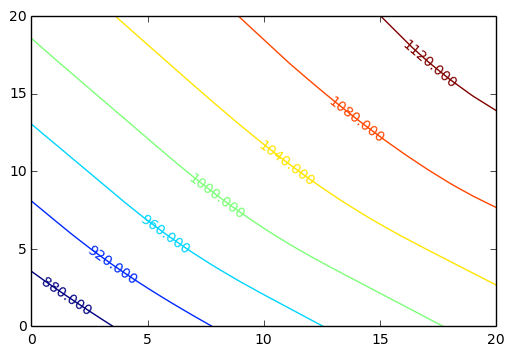

In [1]:
%matplotlib inline
from __future__ import print_function
import math
import matplotlib.pyplot as plt
import numpy as np


MAX_CARS = 20
MAX_MOVE_OF_CARS = 5
MAX_X_OF_POISON = 10

REQUEST_MEAN_1 = 3
REQUEST_MEAN_2 = 4
RETURN_MEAN_1 = 3
RETURN_MEAN_2 = 2

COST_FOR_MOVING_CARS = 2
RENTAL_CREDIT = 10

DISCOUNT = 0.9

CONST_RETURN = True

VERBOSE = False

class Agent():
    def __init__(self):
        self.states = [(i, j) for i in range(0, MAX_CARS+1) for j in range(0, MAX_CARS+1)]
        self.actions = range(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS+1)
        
        self.state_value = dict()
        for state in self.states:
            self.state_value[state] = 0
            
        self.policy = dict()      
        for state in self.states:
            self.policy[state] = 0
            
        self.poisson_lookup_table = dict()
    
    
    def calc_poisson_prob(self, x, mean):
        ''' return exp(-mean) * mean^x / x! '''
        if x not in self.poisson_lookup_table:
            p = math.exp(-mean)
            for i in xrange(x):
                p *= mean
                p /= i+1
            self.poisson_lookup_table[x] = p
        return self.poisson_lookup_table[x]
    
    
    def calc_action_value(self, state, action):
        ''' return q(s, a)'''
        
        expected_action_value = -COST_FOR_MOVING_CARS * abs(action)
        # enumerate all the (s', r) given (s, a)
        for i in range(MAX_X_OF_POISON):
            for j in range(MAX_X_OF_POISON):
                request_new_state = (int(min(state[0]-action, MAX_CARS)), 
                                     int(min(state[1]+action, MAX_CARS)))
                rentals = (min(i, request_new_state[0]), min(j, request_new_state[1]))
                request_new_state = (request_new_state[0]-rentals[0], 
                                     request_new_state[1]-rentals[1])   
                
                request_prob = self.calc_poisson_prob(i, REQUEST_MEAN_1) * \
                    self.calc_poisson_prob(j, REQUEST_MEAN_2)
                reward = RENTAL_CREDIT * (rentals[0] + rentals[1])
                
                # get returned cars at the end of the day
                if CONST_RETURN:
                    
                    return_new_state = (min(RETURN_MEAN_1+request_new_state[0], MAX_CARS), 
                                        min(RETURN_MEAN_2+request_new_state[1], MAX_CARS))   
                    expected_action_value += (request_prob * \
                                              (reward + DISCOUNT * self.state_value[return_new_state])) 
                else:
                    for m in range(MAX_X_OF_POISON):
                        for n in range(MAX_X_OF_POISON):
                            return_new_state = (min(m+request_new_state[0], MAX_CARS), 
                                       min(n+request_new_state[1], MAX_CARS))   
                            return_prob = self.calc_poisson_prob(m, RETURN_MEAN_1) * \
                                self.calc_poisson_prob(n, RETURN_MEAN_2) 
                            expected_action_value += (request_prob * return_prob * \
                                                      (reward + DISCOUNT * self.state_value[return_new_state]))
                            
        return expected_action_value
    
    
    def policy_evaluation(self):
        max_residual = float('inf')
        while max_residual > 1e-1:
            new_state_value = dict()
            max_residual = 0.0
            for state in self.states:
                action = self.policy[state]
                old_value = self.state_value[state]
                new_state_value[state] = self.calc_action_value(state, action)
                residual = abs(new_state_value[state] - old_value)
                if residual > max_residual:
                    max_residual = residual
            if VERBOSE:
                print('policy_evaluation -- max_residual', max_residual)
            self.state_value = new_state_value


    def policy_improvement(self):
        policy_stable = True
        new_policy = dict()
        for state in self.states:
            old_action = self.policy[state]
            qs = []
            for action in self.actions:
                if (action >= 0 and state[0] - action >= 0) or (action <= 0 and state[1] + action >= 0):
                    q = self.calc_action_value(state, action)
                    qs.append(q)
                else:
                    qs.append(-float('inf'))
            new_action = self.actions[np.argmax(qs)]
            new_policy[state] = new_action
            if new_action != old_action:
                policy_stable = False
        
        self.policy = new_policy
        return policy_stable
    
    def policy_iteration(self):
        iter_cnt = 0
        while True:
            iter_cnt += 1
            
            print('iter_cnt: %d' % iter_cnt)
            print('policy_improvement')
            if self.policy_improvement():
                print('policy_improvement break')
                break
            
            self.policy_evaluation()

            
agent = Agent()
agent.policy_iteration()

def show(table):
    Z = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    for i, j in agent.states:
        Z[i][j] = table[(i, j)]

    CS = plt.contour(Z)
    plt.clabel(CS, inline=False)
    plt.show()

''' show state_value '''
show(agent.state_value)